In [1]:
from encoder_decoder_model import load_pretrained_enc_dec_model, init_dit_bart_models_fixed, init_dit_dbart_models
from func_utils.pydataloader import SynthDogDataset
import matplotlib.pyplot as plt
from glob import glob
import numpy as np  
import torch 
import os 

c:\Users\jaabi\Documents\comudel\ocr\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_synth_images_json_path(data_root= os.path.join('synthdog','outputs'), split='train'):
    ipath = os.path.join(data_root, '*', split, '*.jpg')
    json_path = os.path.join(data_root, '*', split, 'metadata.jsonl')

    return glob(ipath), glob(json_path)

decode_to_portuguese = lambda x : x.replace('Ġ','').encode('iso-8859-1').decode('utf-8')
torch.cuda.empty_cache()

In [35]:
## hyper-params 
max_token_size = 512
fetch_from_supabase = False
sample_size = 100
lora_config = {
        'r'              : 32,
        'alpha'          : 32*2,
        'dropout'        : 0.35,
        'target_modules' : ["q_proj", "k_proj", "v_proj", "out_proj"],
        'modules_to_save': None
        }
pre_trained_ckpt_path = os.path.join('saved_models', 'mydit_dbart', 'checkpoint-22498')
root_path = os.path.join('synthdog', 'outputs_ol')

In [36]:
# image_processor, text_tokenizer = init_dit_bart_models_fixed(load_model=False)
# model = load_pretrained_enc_dec_model(pre_trained_ckpt_path, **lora_config )
# model.generation_config.decoder_start_token_id = text_tokenizer.bos_token_id

image_processor, text_tokenizer = init_dit_dbart_models(load_model=False)
model = load_pretrained_enc_dec_model(pre_trained_ckpt_path, None, "naver-clova-ix/donut-base", lora_applied=False, 
                                      new_tokens=['Ã', 'Ê', 'Â'])
test_image_path, test_json_metadata = get_synth_images_json_path(data_root=root_path, split='train')
test_dataset = SynthDogDataset(image_path=test_image_path,output_jsons_path=test_json_metadata, image_feature_extractor=image_processor, 
                                    text_tokenizer=text_tokenizer, max_token_size=max_token_size, sample_size=sample_size, 
                                    read_images_from_supabase=fetch_from_supabase, split='train') 

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 730.08it/s]


loading pre-trained tokenizer
Loaded the pre-trained model successfully...
['synthdog\\outputs_ol\\SynthDoG_en\\train\\image_0.jpg', 'synthdog\\outputs_ol\\SynthDoG_en\\train\\image_1.jpg']
Sampled lang counter: {'en': 50, 'pt': 50}
Length of _.images: 100 | Length of _.json_metadata: 32011


In [37]:
model.eval()

VisionEncoderDecoderModel(
  (encoder): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): BeitIntermediate(
            (dense): Linear(in_

In [38]:
model.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "max_length": 1056,
  "min_length": 1,
  "pad_token_id": 1,
  "repetition_penalty": 1.5
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58431375..1.0].


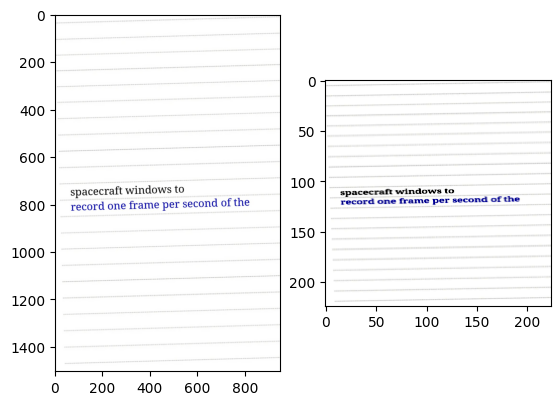

In [49]:
sample = test_dataset[np.random.randint(0, len(test_dataset))]

plt.subplot(1,2, 1)
plt.imshow(sample['image']);
plt.subplot(1,2, 2)
plt.imshow(sample['pixel_values'].permute(1,-1,0));

In [50]:
p = model.generate(sample['pixel_values'].unsqueeze(0)).squeeze(0)
ptext = text_tokenizer.decode(p)
gtokens = sample['labels'].tolist()
print("GT token")
print(gtokens)
print("Model token")
print(p.tolist())
print()
print()
print("GT text")
print(text_tokenizer.decode(gtokens))
print("Pred text")
print(ptext)


GT token
[0, 36833, 45008, 44522, 41641, 16530, 14754, 34503, 5051, 4074, 18080, 2587, 48941, 2]
Model token
[0, 42990, 43754, 11813, 46192, 45118, 5051, 15802, 51139, 19222, 4074, 2587, 2]


GT text
<s> spacecraft windows to record one frame per second of the</s>
Pred text
<s> est suites thecent have be per of</s>


In [65]:
from transformers import VisionEncoderDecoderModel, AutoImageProcessor, AutoTokenizer

def preprocess_image(image):
    pimage = dprocessor(image, return_tensors="pt").pixel_values
    return pimage.to('cuda')
    
name = "naver-clova-ix/donut-base"
dprocessor = AutoImageProcessor.from_pretrained(name)
dtokenizer = AutoTokenizer.from_pretrained(name)
dmodel = VisionEncoderDecoderModel.from_pretrained(name).to('cuda')
dmodel.eval()

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1003.18it/s]


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

In [66]:
from PIL import Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


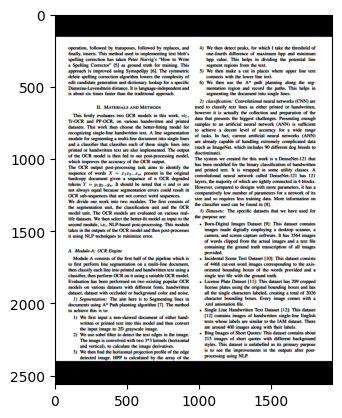

In [74]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', '1.png'))
pimage = preprocess_image(i)
plt.imshow(pimage.squeeze(0).cpu().permute(1,-1,-0))

In [76]:
dmodel.generate(pimage)

tensor([[0, 2]], device='cuda:0')

In [77]:
VisionEncoderDecoderModel.from_pretrained(name)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )